# Models
I just ran `convert_to_np.py`. Let's make sure everything went OK first.

# Helpers

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Intersection over Union
![](extra/iou.png)

In [5]:
class iou_module(nn.Module):
    def __init__(self):
        super(iou_module,self).__init__()

    def forward(self, y_pred, y):
        loss = iou_loss(y_pred, y)
        return loss
    
def iou_score(y_pred, y, SMOOTH=1e-6, rounding=False):
    """
    aka Jaccard
    expect: y_pred, y to be of SAME integer type
    
    y_pred is output of model
        expect: y_pred.shape = (batch_len,D,D,S)
        (no channels!)
    y is truth value (labels)
        expect: y.shape = (batch_len,D,D,S)
    
    returns: the mean across the batch of the iou scores
    """
    # sanity check
    assert y_pred.shape == y.shape
    # to compute scores, we sum along all axes except for batch
    axes = tuple([i for i in range(1,len(y.shape))])
    batch_len = y.shape[0]
    # if y_pred hasn't been rounded
    if rounding:
        y_pred = y_pred.round()
    
    intersection = (y_pred & y).sum(dim=axes).float()
    union = (y_pred | y).sum(dim=axes).float()
    # sanity check
    assert intersection.shape == union.shape
    assert union.shape == (batch_len,)
    
    iou = 1 - (intersection + SMOOTH) / (union + SMOOTH)
    
    return iou.mean()

def iou_loss(y_pred, y, SMOOTH=1e-6):
    """
    essentially returns 1 - iou_score
    but takes care of y_pred not being rounded
    """
    assert y_pred.shape == y.shape
    axes = tuple([i for i in range(1,len(y.shape))])
    batch_len = y.shape[0]
    
    numerator = y*y_pred
    numerator = numerator.sum(dim=axes)
    a = y.sum(dim=axes)
    b = y.sum(dim=axes)
    denominator = a + b - numerator
    quotient = (numerator + SMOOTH) / (denominator + SMOOTH)
    return quotient.mean()


### Simulator

In [6]:
def simulator(model,criterion,score_fun,batch_len=1,C=4,D=32,S=64):
    """
    Creates source data x of shape (batch_len,C,D,D,S).
    Creates target data y of shape (batch_len,D,D,S).
    Creates prediction data y_pred using model(x).
    Computes loss using criterion(y_pred,y).
        NOTE: the order of arguments may matter.
    """
    # simulate input data
    x = torch.randn(batch_len,C,D,D,S)
    print(f"Input has shape {tuple(x.shape)}.")
    # simulate output data
    y = torch.randn(batch_len,D,D,S)
    y = torch.sigmoid(y).round()
    print(f"Target has shape {tuple(y.shape)}.")
    # simulate prediction for training
    y_pred = model(x, evaluating=False)
    print(f"Training output has shape {tuple(y_pred.shape)}.")
    # compute loss
    loss = criterion(y_pred,y)
    print(f"Loss is {loss.item()}.")
    
    loss.backward()
    print("Backward pass works.")
    
    # simulate prediction for evaluating
    y_pred = model(x, evaluating=True)
    print(f"Evaluation output has shape {tuple(y_pred.shape)}.")
    # convert to int type
    # x.byte() is equivalent to x.to(dtype=torch.uint8)
    # https://pytorch.org/docs/stable/tensors.html
    y_pred = y_pred.byte()
    y = y.byte()
    score = score_fun(y_pred,y).item()
    print(f"Score is {score}.")

    # simulate segmentation comparison
    y_pred = y_pred[0].cpu().detach().numpy()
    y = y[0].cpu().detach().numpy()
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(y_pred[:,:,35])
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(y[:,:,35])
    
    plt.show()

#### Pixel-by-pixel logistic regression (bad for your health)

In [7]:
# Pixelwise Logistic Regression (don't run)
class PixLog(nn.Module):
    def __init__(self,C=4,D=32,S=64):
        super(PixLog,self).__init__()
        
        self.dimensions = (C,D,D,S)
        self.fc = nn.Linear(in_features=C*D*D*S, out_features=D*D*S,bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self, x_in, evaluating=False):
        batch_len = x_in.shape[0]
        x = x_in.view(batch_len,-1)
        x = self.fc(x)
        
        if evaluating:
            x = self.sig(x)
            x = x.round()
        
        dummy_dim = (-1,) + self.dimensions[1:]
        x_out = x.view(dummy_dim)
        return x_out

# If you even try to initialize this, you're gonna have a bad time.

#### Naive encoder-decoder

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.7039296627044678.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 0.6646970510482788.


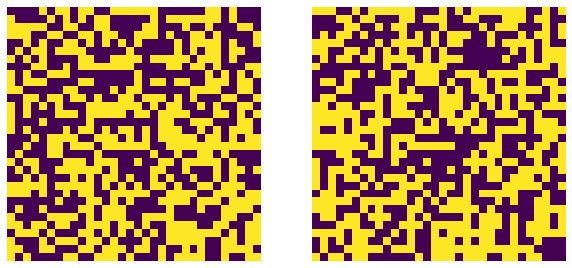

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is -0.00013447196397464722.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 0.6695092916488647.


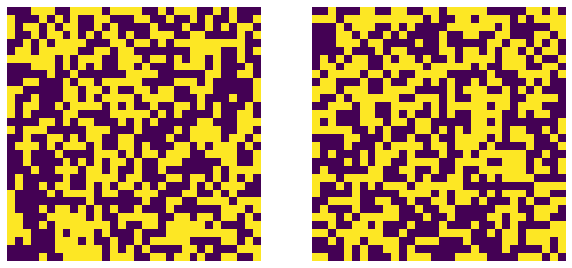

In [8]:
# a simple encoderdecoder-type model
class Crush(nn.Module):
    def __init__(self,D=32,S=64,C=4,crush_size=32):
        super(Crush,self).__init__()
        
        self.dimensions = (C,D,D,S)
        self.in_features = int(D*D*S*C)
        self.crush = crush_size
        self.out_features = int(D*D*S)
        self.enc = nn.Linear(in_features=self.in_features,out_features=self.crush,bias=True)
        self.act = nn.ReLU()
        self.dec = nn.Linear(in_features=self.crush,out_features=self.out_features)
        self.sig = nn.Sigmoid()
    
    def forward(self, x_in, evaluating=False):
        batch_len = x_in.shape[0]
        x = x_in.view(batch_len,-1)
        x = self.enc(x)
        x = self.act(x)
        x = self.dec(x)
        
        if evaluating:
            x = self.sig(x)
            x = x.round()
        
        dummy_dim = (-1,) + self.dimensions[1:]
        x_out = x.view(dummy_dim)
        return x_out


model = Crush()
optimizer = torch.optim.Adam(model.parameters())
simulator(model=model,criterion=nn.BCEWithLogitsLoss(),score_fun=iou_score)
simulator(model=model,criterion=iou_module(),score_fun=iou_score)
# for loss = nn.BCEWithLogitsLoss()
# should be of the form loss(y_pred,y)

#### Simple Sequential CNN
* 4 Convolution layers  
![](extra/conv.gif)  
Image from:
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* ReLU activation
* Batch normalization  
![](extra/batchnorm.png)  
Image from:
https://medium.com/luminovo/a-refresher-on-batch-re-normalization-5e0a1e902960

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.008604518137872219.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 0.5750231742858887.


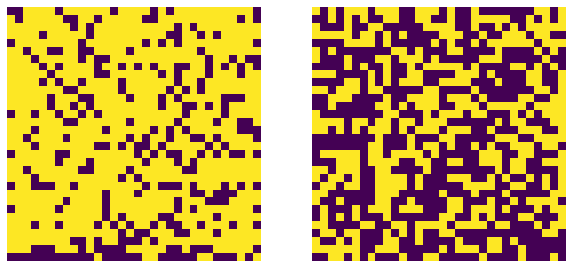

In [18]:
# a simple sequence of convolutional layers
class ConvSeq(nn.Module):
    def __init__(self,input_channels=4):
        super(ConvSeq,self).__init__()
        
        self.input_channels = input_channels
        
        self.c1 = self.ConvLayer(in_channels=self.input_channels)
        self.c2 = self.ConvLayer()
        self.c3 = self.ConvLayer()
        self.cfinal = self.ConvLayer(out_channels=1, relu=False)
    
    def forward(self, x_in, evaluating=False):
        x = self.c1(x_in)
        x = self.c2(x)
        x = self.c3(x)
        x_out = self.cfinal(x).squeeze(1)
        
        if evaluating:
            x_out = torch.sigmoid(x_out)
            x_out = x_out.round()
            
        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True, relu=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())

        return layer


model = ConvSeq()
optimizer = torch.optim.Adam(model.parameters())
criterion = iou_module()
simulator(model=model,criterion=criterion,score_fun=iou_score)

#### Shallow 3d U-net
* Original U-net paper https://arxiv.org/abs/1505.04597
* The skip connection concatenates tensors channel-wise.
* Downsampling is MaxPool.  
![](extra/maxpool.webp)
* Upsampling is nearest neighbor. https://pytorch.org/docs/master/nn.functional.html#interpolate  
![](extra/upsample.png)

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.00027482715086080134.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 0.7494961023330688.


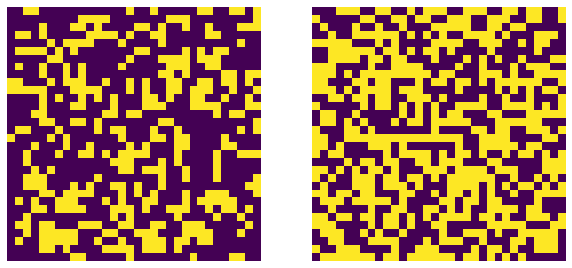

In [20]:
# small 3d u-net with concatenating skip connection
class Small3dUcat(nn.Module):
    def __init__(self,input_channels=4,num_filters=32):
        super(Small3dUcat,self).__init__()
        
        # Structure:
        # Conv,Conv,MaxPool,Conv,Conv,UnPool,Conv,Conv
        
        self.input_channels = input_channels
        self.num_filters = num_filters
        
        self.c1 = self.ConvLayer(in_channels=self.input_channels,out_channels=num_filters)
        self.c2 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)

        self.c3 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c4 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        
        self.c5 = self.ConvLayer(in_channels=2*num_filters,out_channels=num_filters)
        self.c6 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c7 = self.ConvLayer(in_channels=num_filters,out_channels=1)
    
    def forward(self, x_in, evaluating=False):
        x1 = self.c1(x_in)
        x1 = self.c2(x1)
        
        x2 = F.max_pool3d(x1,kernel_size=2)
        x2 = self.c3(x2)
        x2 = self.c4(x2)
        
        x2 = F.interpolate(x2, scale_factor=2)
        # concatenate x1,x2
        x = torch.cat([x1,x2],dim=1)
        x = self.c5(x)
        x = self.c6(x)
        x = self.c7(x)
        
        x_out = x.squeeze(1)
        x_out = torch.sigmoid(x_out)

        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3,
                  stride=1, padding=1, bias=True, relu=True, batchnorm=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())
        if batchnorm:
            layer.add_module('batchnorm',nn.BatchNorm3d(out_channels))

        return layer


model = Small3dUcat()
optimizer = torch.optim.Adam(model.parameters())
criterion = iou_module()
simulator(model=model,criterion=criterion,score_fun=iou_score)

### Shallow 3d U-net again
* Same as above except skip connection adds tensors instead of concatenating.

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.3324456214904785.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 1.0.


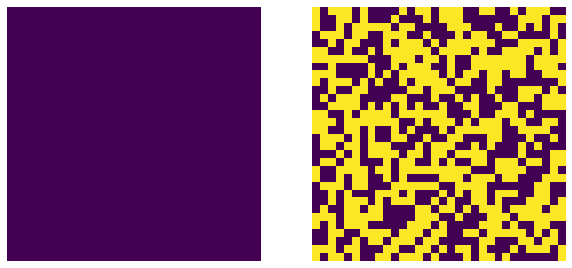

In [11]:
# small 3d u-net with addition skip connection
class Small3dUadd(nn.Module):
    def __init__(self,input_channels=4,num_filters=32):
        super(Small3dUadd,self).__init__()
        
        # Structure:
        # Conv,Conv,MaxPool,Conv,Conv,UnPool,Conv,Conv
        
        self.input_channels = input_channels
        self.num_filters = num_filters
        
        self.c1 = self.ConvLayer(in_channels=self.input_channels,out_channels=num_filters)
        self.c2 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)

        self.c3 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c4 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        
        self.c5 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c6 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c7 = self.ConvLayer(in_channels=num_filters,out_channels=1)
    
    def forward(self, x_in, evaluating=False):
        x1 = self.c1(x_in)
        x1 = self.c2(x1)
        
        x2 = F.max_pool3d(x1,kernel_size=2)
        x2 = self.c3(x2)
        x2 = self.c4(x2)
        
        x2 = F.interpolate(x2, scale_factor=2)
        # add x1,x2
        x = F.relu(x1+x2)
        x = self.c5(x)
        x = self.c6(x)
        x = self.c7(x)
        
        x_out = x.squeeze(1)
        x_out = torch.sigmoid(x_out)

        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3,
                  stride=1, padding=1, bias=True, relu=True, batchnorm=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())
        if batchnorm:
            layer.add_module('batchnorm',nn.BatchNorm3d(out_channels))

        return layer


model = Small3dUadd()
optimizer = torch.optim.Adam(model.parameters())
criterion = iou_module()
simulator(model=model,criterion=criterion,score_fun=iou_score)

### A proper U-net.
![](extra/u.jpg)

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 1.2631392564799171e-05.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 1.0.


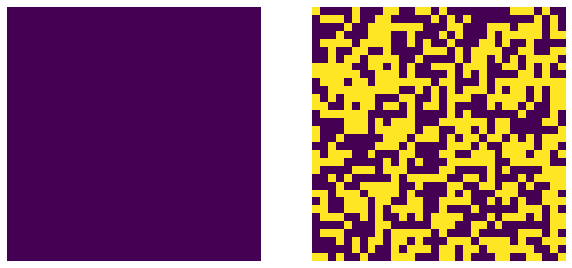

In [14]:
# a proper U-net
# include picture of architecture
# small 3d u-net with addition skip connection
class Unet3d(nn.Module):
    def __init__(self,input_channels=4,num_filters=64):
        super(Unet3d,self).__init__()
        
        # Structure:
        # cccmcccmcccmcccmcccucccucccucccucccf
        
        self.input_channels = input_channels
        c = self.input_channels
        self.num_filters = num_filters
        n = self.num_filters
        
        # down
        self.c1 = self.ConvLayer(in_channels=c,out_channels=n)
        self.c2 = self.ConvLayer(in_channels=n,out_channels=n)
        self.c3 = self.ConvLayer(in_channels=n,out_channels=n)

        self.c4 = self.ConvLayer(in_channels=n,out_channels=2*n)
        self.c5 = self.ConvLayer(in_channels=2*n,out_channels=2*n)
        self.c6 = self.ConvLayer(in_channels=2*n,out_channels=2*n)

        self.c7 = self.ConvLayer(in_channels=2*n,out_channels=4*n)
        self.c8 = self.ConvLayer(in_channels=4*n,out_channels=4*n)
        self.c9 = self.ConvLayer(in_channels=4*n,out_channels=4*n)

        self.c10 = self.ConvLayer(in_channels=4*n,out_channels=8*n)
        self.c11 = self.ConvLayer(in_channels=8*n,out_channels=8*n)
        self.c12 = self.ConvLayer(in_channels=8*n,out_channels=8*n)

        self.c13 = self.ConvLayer(in_channels=8*n,out_channels=16*n)
        self.c14 = self.ConvLayer(in_channels=16*n,out_channels=16*n)
        self.c15 = self.ConvLayer(in_channels=16*n,out_channels=16*n)
        
        # up
        self.c16 = self.ConvLayer(in_channels=16*n+8*n,out_channels=8*n)
        self.c17 = self.ConvLayer(in_channels=8*n,out_channels=8*n)
        self.c18 = self.ConvLayer(in_channels=8*n,out_channels=8*n)

        
        self.c19 = self.ConvLayer(in_channels=8*n+4*n,out_channels=4*n)
        self.c20 = self.ConvLayer(in_channels=4*n,out_channels=4*n)
        self.c21 = self.ConvLayer(in_channels=4*n,out_channels=4*n)

        
        self.c22 = self.ConvLayer(in_channels=4*n+2*n,out_channels=2*n)
        self.c23 = self.ConvLayer(in_channels=2*n,out_channels=2*n)
        self.c24 = self.ConvLayer(in_channels=2*n,out_channels=2*n)

        self.c25 = self.ConvLayer(in_channels=2*n+n,out_channels=n)
        self.c26 = self.ConvLayer(in_channels=n,out_channels=n)
        self.c27 = self.ConvLayer(in_channels=n,out_channels=n)
        
        self.f = self.ConvLayer(in_channels=n,out_channels=1,
                                kernel_size=1,padding=0)

    def forward(self, x_in, evaluating=False):
        x = self.c1(x_in)
        x = self.c2(x)
        x3 = self.c3(x)
        
        x = F.max_pool3d(x3,kernel_size=2)
        x = self.c4(x)
        x = self.c5(x)
        x6 = self.c6(x)
        
        x = F.max_pool3d(x6,kernel_size=2)
        x = self.c7(x)
        x = self.c8(x)
        x9 = self.c9(x)
        
        x = F.max_pool3d(x9,kernel_size=2)
        x = self.c10(x)
        x = self.c11(x)
        x12 = self.c12(x)
        
        x = F.max_pool3d(x12,kernel_size=2)
        x = self.c13(x)
        x = self.c14(x)
        x = self.c15(x)
        
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x,x12],dim=1)
        x = self.c16(x)
        x = self.c17(x)
        x = self.c18(x)
        
        x = F.interpolate(x,scale_factor=2)
        x = torch.cat([x,x9],dim=1)
        x = self.c19(x)
        x = self.c20(x)
        x = self.c21(x)
        
        x = F.interpolate(x,scale_factor=2)
        x = torch.cat([x,x6],dim=1)
        x = self.c22(x)
        x = self.c23(x)
        x = self.c24(x)
        
        x = F.interpolate(x,scale_factor=2)
        x = torch.cat([x,x3],dim=1)
        x = self.c25(x)
        x = self.c26(x)
        x = self.c27(x)
        
        x = self.f(x)
        x_out = x.squeeze(1)

        return x_out
        
#         # remove the sigmoid when copying to models.py
#         x_out = x.squeeze(1)
#         x_out = torch.sigmoid(x_out)

        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3,
                  stride=1, padding=1, bias=True, relu=True, batchnorm=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())
        if batchnorm:
            layer.add_module('batchnorm',nn.BatchNorm3d(out_channels))

        return layer


model = Unet3d()
optimizer = torch.optim.Adam(model.parameters())
criterion = iou_module()
simulator(model=model,criterion=criterion,score_fun=iou_score)

### Double U-net  
![](extra/uu.png)  
Taken from https://arxiv.org/pdf/1701.03056.pdf (with minor differences)  
![](extra/myuu.png)
* Downsampling is Conv with 2x2 kernel, stride=2.
* Has PReLU activations.
* Upsampling is now the transpose of downsampling.  
![](extra/tconv.gif)
* Uses 1d convolutions to reduce channels.   
![](extra/1dconv.png)

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.15647375583648682.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
Score is 0.6155891418457031.


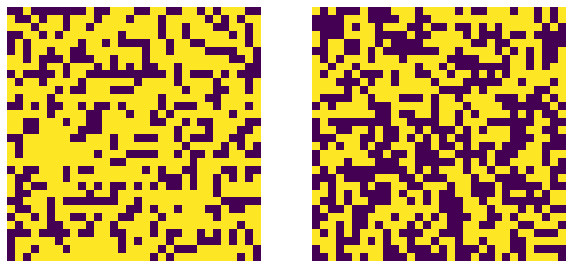

In [24]:
# 3d UU-net
class Big3dU(nn.Module):
    def __init__(self,input_channels=4):
        super(Big3dU,self).__init__()
        
        self.c0 = self.ConvLayer(in_channels=4,out_channels=8,
                                 kernel_size=3,stride=1,padding=1)

        self.d1 = self.ConvLayer(in_channels=8,out_channels=16,
                                 stride=2,kernel_size=2,padding=0)
        self.c1 = self.ConvLayer(in_channels=16,out_channels=16,
                                kernel_size=3,stride=1,padding=1)

        self.d2 = self.ConvLayer(in_channels=16,out_channels=32,
                                 stride=2,kernel_size=2,padding=0)
        self.c2 = self.ConvLayer(in_channels=32,out_channels=32,
                                kernel_size=3,stride=1,padding=1)

        self.d3 = self.ConvLayer(in_channels=32,out_channels=64,
                                 stride=2,kernel_size=2,padding=0)
        self.c3 = self.ConvLayer(in_channels=64,out_channels=64,
                                kernel_size=3,stride=1,padding=1)
        
        self.f1 = self.ConvLayer(in_channels=64,out_channels=32,
                                kernel_size=1,stride=1,padding=0)
        
        self.u1 = self.ConvLayer(in_channels=32,out_channels=32,
                                kernel_size=2,stride=2,padding=0,transpose=True)
        self.c4 = self.ConvLayer(in_channels=64,out_channels=32,
                                 kernel_size=3,stride=1,padding=1)
        self.f2 = self.ConvLayer(in_channels=32,out_channels=16,
                                kernel_size=1,stride=1,padding=0)
        
        self.u2 = self.ConvLayer(in_channels=16,out_channels=16,
                                kernel_size=2,stride=2,padding=0,transpose=True)
        self.c5 = self.ConvLayer(in_channels=32,out_channels=16,
                                kernel_size=3,stride=1,padding=1)
        self.f3 = self.ConvLayer(in_channels=16,out_channels=8,
                                kernel_size=1,stride=1,padding=0)
        
        self.u3 = self.ConvLayer(in_channels=8,out_channels=8,
                                kernel_size=2,stride=2,padding=0,transpose=True)
        self.c6 = self.ConvLayer(in_channels=16,out_channels=16,
                                kernel_size=3,stride=1,padding=1)
        
        self.f4 = self.ConvLayer(in_channels=32,out_channels=16,
                                kernel_size=1,stride=1,padding=0)
        self.f5 = self.ConvLayer(in_channels=16,out_channels=8,
                                kernel_size=1,stride=1,padding=0)
        self.f6 = self.ConvLayer(in_channels=16,out_channels=1,
                                kernel_size=1,stride=1,padding=0)
        
        self.u4 = self.ConvLayer(in_channels=16,out_channels=8,
                                kernel_size=2,stride=2,padding=0,transpose=True)
        self.u5 = self.ConvLayer(in_channels=8,out_channels=1,
                                kernel_size=2,stride=2,padding=0,transpose=True)
        
        self.act = nn.PReLU(num_parameters=1)  

    def forward(self, x_in, evaluating=False):
        x0 = self.c0(x_in)
        x1 = self.d1(x0)
        x2 = self.c1(x1)
        x3 = self.d2(x2+x1)
        x4 = self.c2(x3)
        x5 = self.d3(x4+x3)
        x6 = self.c3(x5)
        x7 = self.f1(x6+x5)
        x8 = self.u1(x7)
        x9 = self.c4(torch.cat([x8,x4],dim=1))
        x10 = self.f2(x9)
        x11 = self.u2(x10)
        x12 = self.c5(torch.cat([x11,x2],dim=1))
        x13 = self.f3(x12)
        x14 = self.u3(x13)
        x15 = self.f4(x9)
        x16 = self.u4(x15)
        x17 = self.f5(x12)
        # x18 is missing, the graph I sketched had a box I did not use
        x19 = self.u5(x16+x17)
        x20 = self.c6(torch.cat([x14,x0],dim=1))
        x21 = self.f6(x20)
        x22 = self.act(x21+x19)

        x_out = x22.squeeze(1)
        x_out = torch.sigmoid(x_out)

        return x_out

    def ConvLayer(self,in_channels,out_channels,kernel_size,
                  stride,padding,dilation=1,bias=True,prelu=True,batchnorm=True,transpose=False):
        layer = nn.Sequential()
        if transpose:
            tconv = nn.ConvTranspose3d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding,
                             dilation=dilation,
                             bias=bias)
            layer.add_module('tconv',tconv)
        else:
            conv = nn.Conv3d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding,
                             dilation=dilation,
                             bias=bias)
            layer.add_module('conv',conv)

        if batchnorm:
            layer.add_module('batchnorm',nn.BatchNorm3d(num_features=out_channels))

        if prelu:
            layer.add_module('prelu',nn.PReLU(num_parameters=out_channels))

        return layer

model = Big3dU()
optimizer = torch.optim.Adam(model.parameters())
criterion = iou_module()
simulator(model=model,criterion=criterion,score_fun=iou_score)